Tensorflow에서 제공하는 mnist image set으로 GAN 실습
mnist image set은 28 * 28 사이즈의 숫자 손글씨

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [20]:
X_train.shape

(60000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

정규화 -> generator에서 tanh를 activation으로 활용 => output이 -1 ~ 1 사이로 나옴 -> 127.5로 나눈 뒤 1 빼기

In [22]:
X_train.min(), X_train.max()

(0, 255)

In [23]:
X_train = X_train / 127.5 -1
X_test = X_test / 127.5 -1

In [24]:
X_train.min(), X_train.max()

(-1.0, 1.0)

28 * 28 을 Flatten -> 차원 축소

In [25]:
X_train = X_train.reshape(-1, 784)
X_train.shape

(60000, 784)

Hyperparameters

In [26]:
NOISE_DIM = 10

In [27]:
adam = Adam(learning_rate = 0.0002, beta_1 = 0.5)

Generator 생성자 정의

In [28]:
generator = Sequential([
    Input(shape=(NOISE_DIM,)),
    Dense(256),
    LeakyReLU(0.2),
    Dense(512),
    LeakyReLU(0.2),
    Dense(1024),
    LeakyReLU(0.2),
    Dense(28*28, activation = 'tanh'),
])

In [29]:
generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,463,312 (5.58 MB)

 Trainable params: 1,463,312 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

Discriminator 판별자 정의

In [55]:
discriminator = Sequential([
    Input(shape=(784,)),
    Dense(1024, kernel_initializer = RandomNormal(stddev = 0.02)),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(512),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(256),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [31]:
discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# 판별자를 binary_crossentropy 로스를 가지도록 compile

discriminator.compile(loss = 'binary_crossentropy', optimizer = adam)

GAN 구성 - 생성자와 판별자 연결 (GAN 모델에서는 생성자만 학습하고, 판별자는 학습하지 않음)

In [33]:
discriminator.trainable = False
gan_input = Input(shape = (NOISE_DIM,))
x = generator(inputs = gan_input)
output = discriminator(x)

In [34]:
gan = Model(gan_input, output)

In [35]:
gan.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 784)            │     1,463,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 1)              │     1,460,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,923,537 (11.15 MB)

 Trainable params: 1,463,312 (5.58 MB)

 Non-trainable params: 1,460,225 (5.57 MB)

In [36]:
# compile

gan.compile(loss = 'binary_crossentropy', optimizer = adam)

In [37]:
# batch - mnist 이미지 batch가 차례대로 생성되도록 이미지 batch 생성

def get_batches(data, batch_size) :
    batches = []
    for i in range(int(data.shape[0] // batch_size)) :
        batch = data[i * batch_size : (i+1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [38]:
X_train.shape

(60000, 784)

In [39]:
# 784개 피쳐를 가진 6천개 * 10 데이터로 변환

get_batches(X_train, 10).shape

(6000, 10, 784)

In [40]:
# 시각화 유틸 함수 정의

""" def visualize_training(epoch, d_losses, g_losses, generated_images) :
    plt.figure(figsize = (8, 4))
    
    plt.plot(d_losses, label = "Discriminator Loss")
    plt.plot(g_losses, label = "Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    print("epoch: {}, Discriminator Loss: {}, Generator Loss: {}".format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))

    # 샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generator_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize = (8, 4))

    for i in range(generated_images.shape[0]) :
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show() """

def visualize_training(epoch, d_losses, g_losses, generated_images):
    plt.figure(figsize = (10, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label = "Discriminator Loss")
    plt.plot(g_losses, label = "Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")

    # 생성된 이미지 샘플 출력
    plt.subplot(1, 2, 2)
    for i in range(min(16, generated_images.shape[0])):  # 최대 16개까지만 출력
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap = 'gray', interpolation = 'nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [41]:
# 학습 과정 -> batch size= 256, epoch = 50
# 적절한 batch size는 학습 속도와 학습 성능에 영향 미침
BATCH_SIZE = 256
EPOCHS = 50

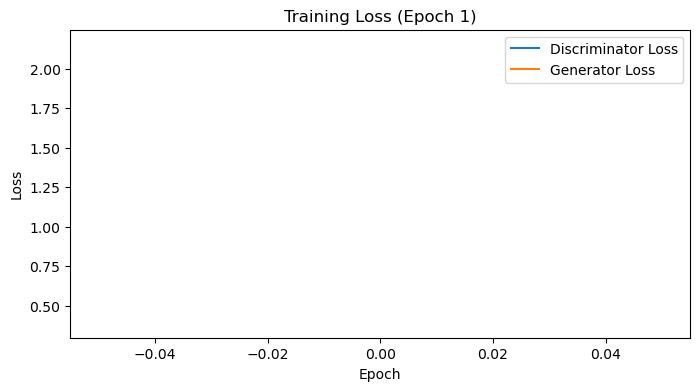

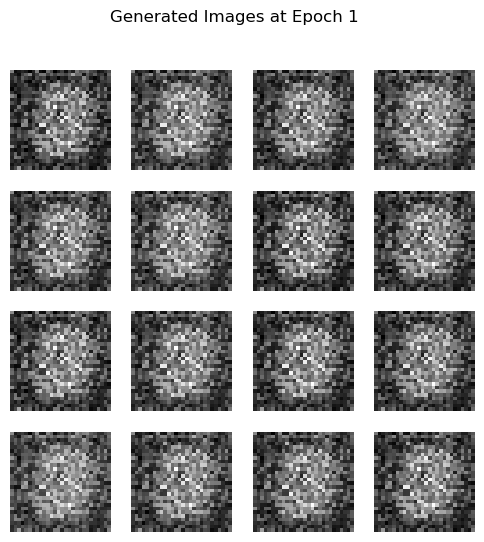

Discriminator Loss: 0.3847424387931824, Generator Loss: 2.158639430999756


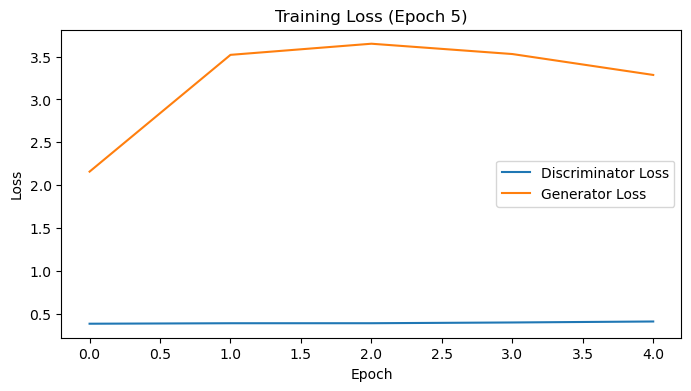

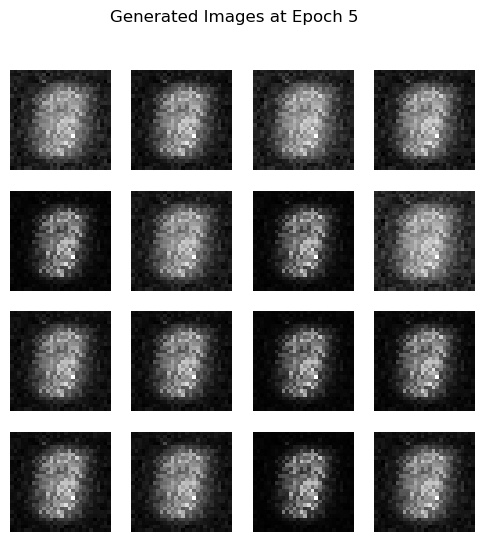

Discriminator Loss: 0.41074445843696594, Generator Loss: 3.286166191101074


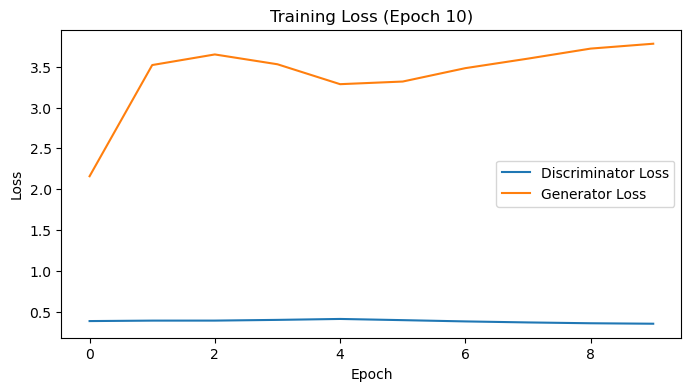

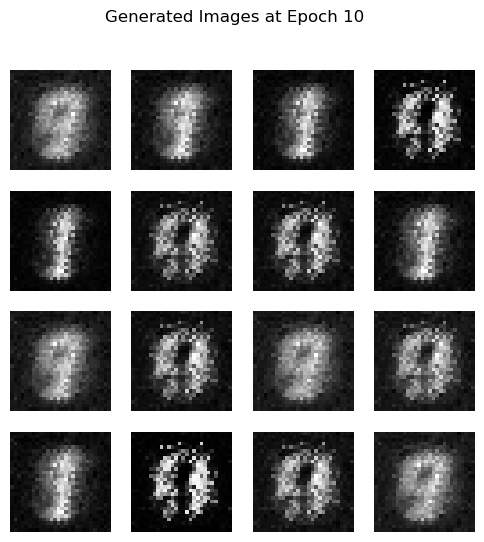

Discriminator Loss: 0.35231226682662964, Generator Loss: 3.7816386222839355


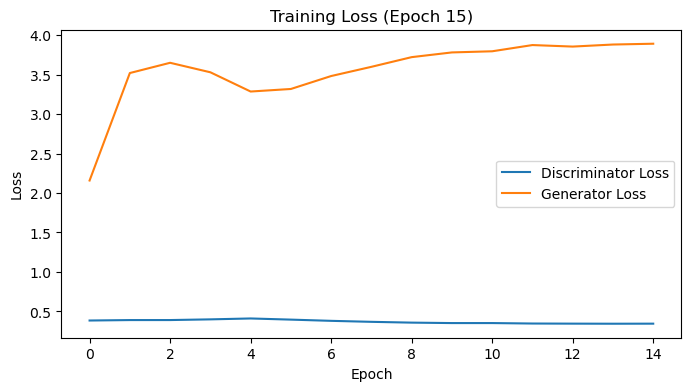

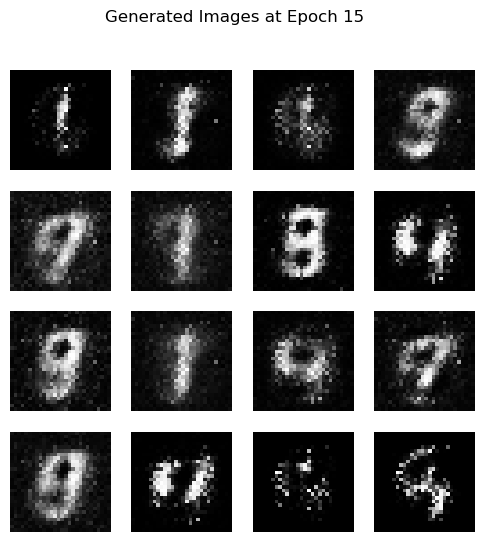

Discriminator Loss: 0.3449007272720337, Generator Loss: 3.891888380050659


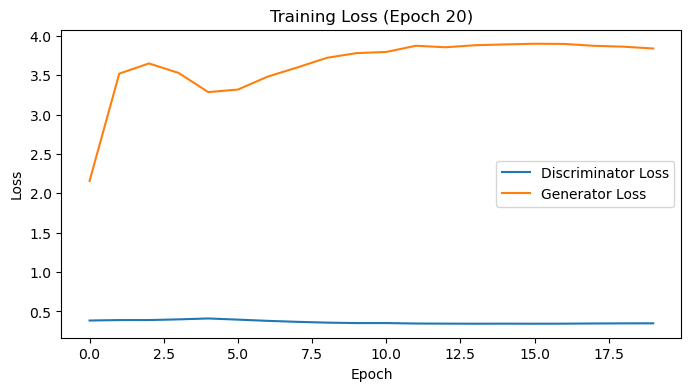

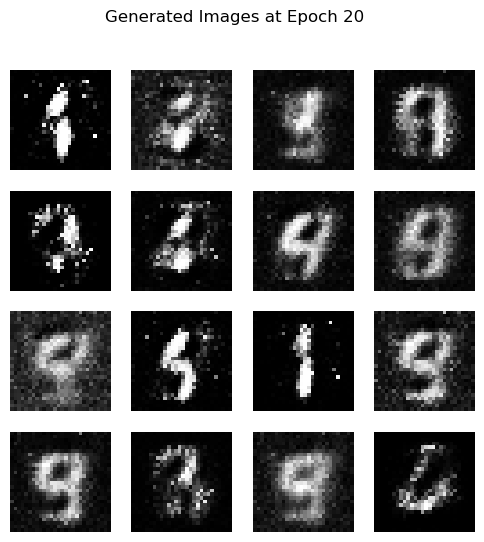

Discriminator Loss: 0.34924671053886414, Generator Loss: 3.8398220539093018


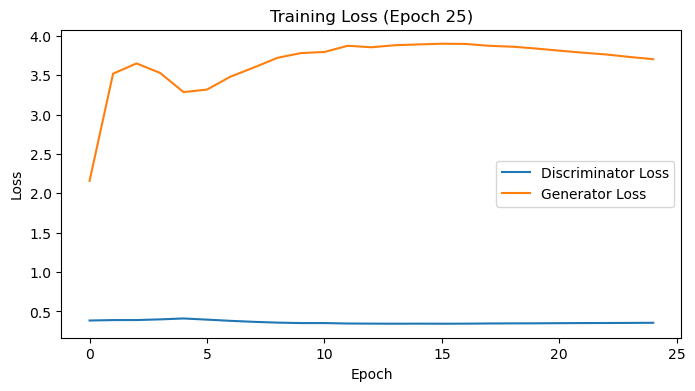

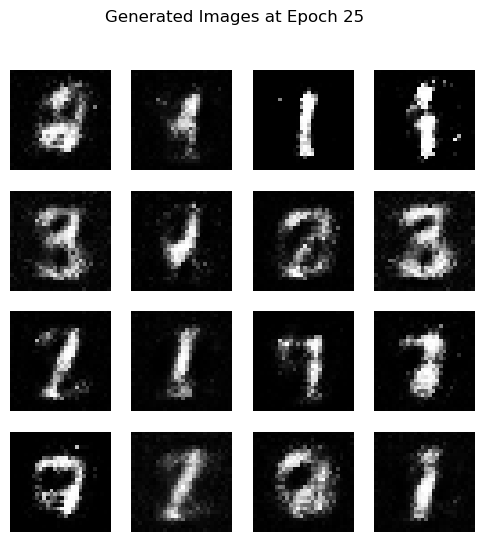

Discriminator Loss: 0.35590440034866333, Generator Loss: 3.704399347305298


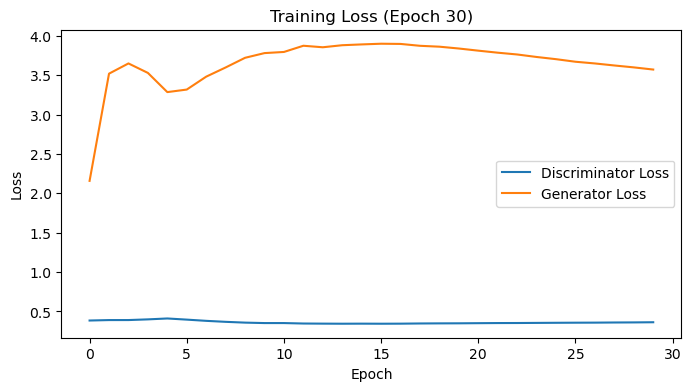

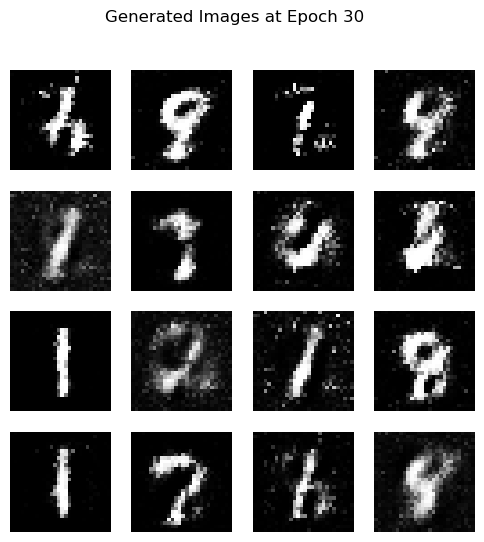

Discriminator Loss: 0.36286330223083496, Generator Loss: 3.5727126598358154


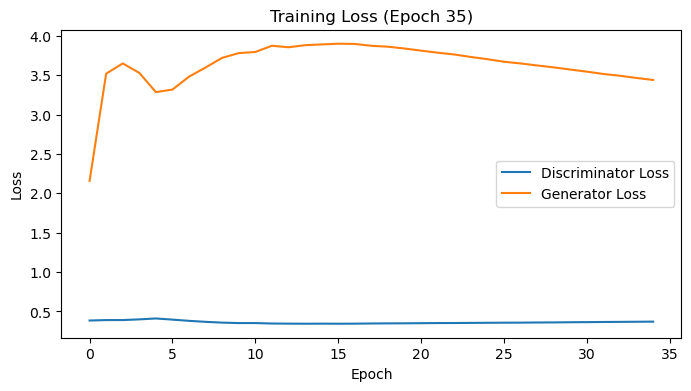

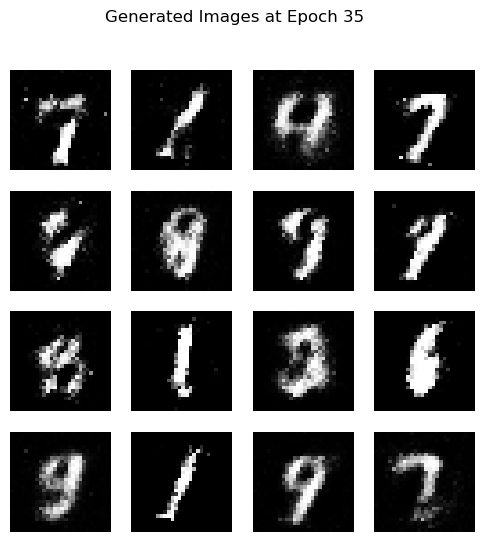

Discriminator Loss: 0.37055179476737976, Generator Loss: 3.4401187896728516


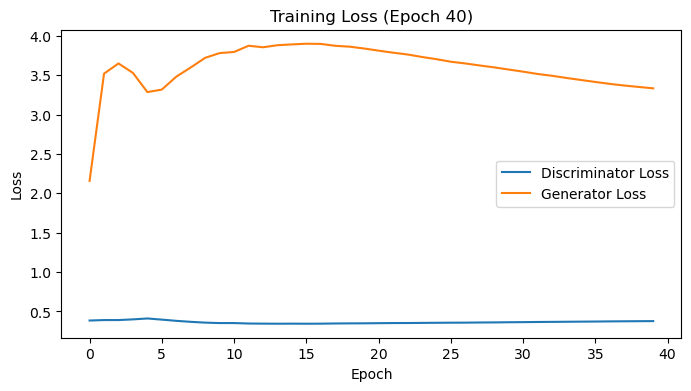

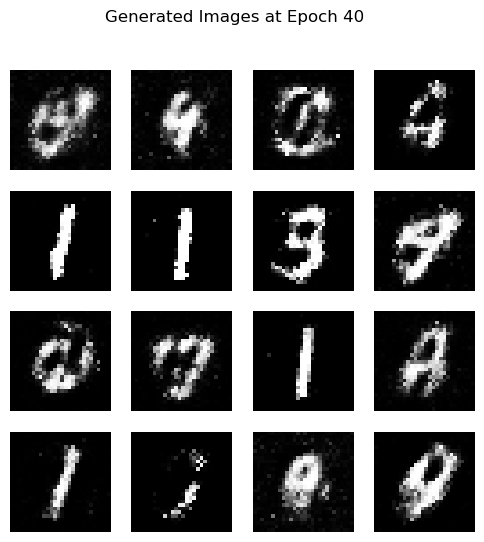

Discriminator Loss: 0.37727054953575134, Generator Loss: 3.3341541290283203


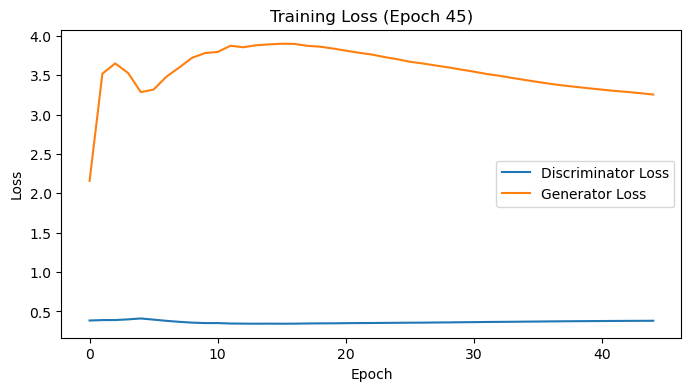

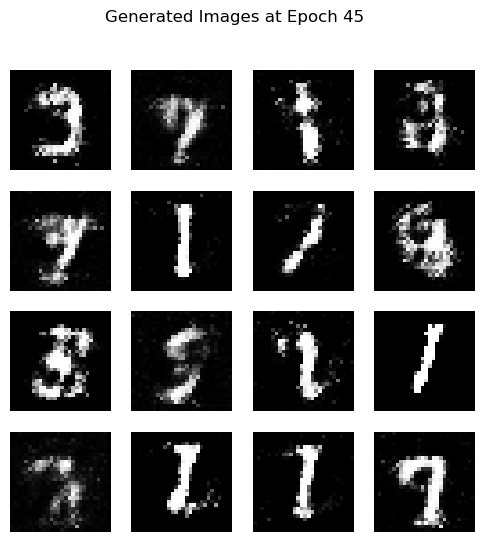

Discriminator Loss: 0.38173431158065796, Generator Loss: 3.2553744316101074


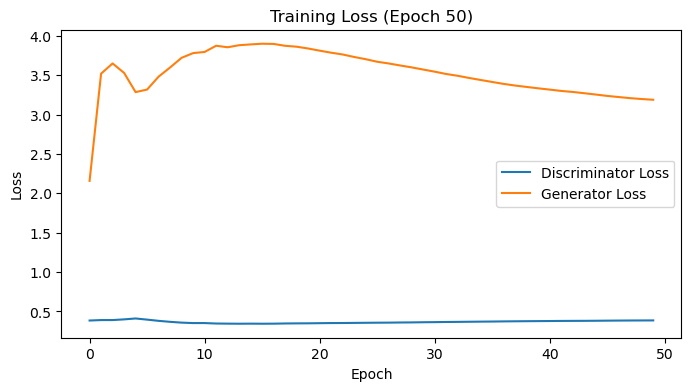

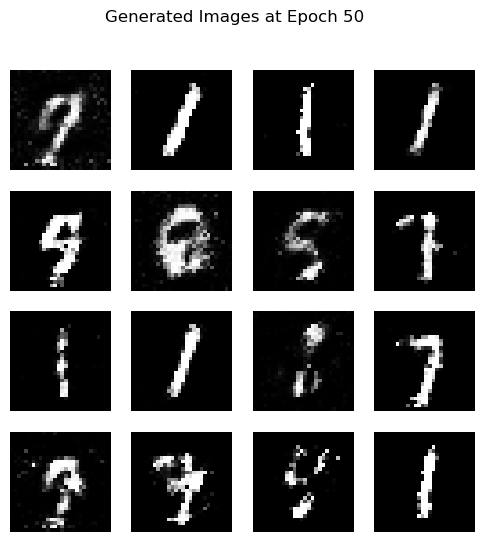

Discriminator Loss: 0.38605961203575134, Generator Loss: 3.1889193058013916


In [42]:
def visualize_loss(epoch, d_losses, g_losses):
    """ 손실 그래프 출력 """
    plt.figure(figsize = (8, 4))
    plt.plot(d_losses, label = "Discriminator Loss")
    plt.plot(g_losses, label = "Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training Loss (Epoch {epoch})")
    
    plt.show()

def visualize_generated_images(epoch, generator, noise_dim = 100):
    """ GAN이 생성한 이미지 출력 """
    noise = np.random.uniform(-1, 1, size = (16, noise_dim))
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize = (6, 6))
    for i in range(16):  # 4x4 그리드
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], cmap = 'gray', interpolation = 'nearest')
        plt.axis('off')

    plt.suptitle(f"Generated Images at Epoch {epoch}")
    
    plt.show()

# 모델 컴파일
generator.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002))
discriminator.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002))
gan.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002))

# 손실 저장 리스트
d_losses = []
g_losses = []

# 훈련 루프
for epoch in range(1, EPOCHS + 1):
    for real_images in get_batches(X_train, BATCH_SIZE):
        
        # 1. 가짜 이미지 생성
        input_noise = np.random.uniform(-1, 1, size = (BATCH_SIZE, NOISE_DIM))
        generated_images = generator.predict(input_noise, verbose=0) # verbose=0: progress bar 삭제

        # 2. Discriminator 훈련 데이터 준비
        X_dis = np.concatenate([real_images, generated_images])
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9  # Label smoothing 적용

        # 3. Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X_dis, y_dis)

        # 4. Generator 훈련 (Discriminator를 고정)
        noise = np.random.uniform(-1, 1, size = (BATCH_SIZE, NOISE_DIM))
        y_gan = np.ones(BATCH_SIZE)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)

    # 손실 저장
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 5. 5 Epoch마다 시각화 (손실 그래프와 생성된 이미지 분리)
    if epoch == 1 or epoch % 5 == 0:
        visualize_loss(epoch, d_losses, g_losses)
        visualize_generated_images(epoch, generator, NOISE_DIM)
        print("Discriminator Loss: {}, Generator Loss: {}".format(d_loss, g_loss))

50 에포크까지 약 15분 소요

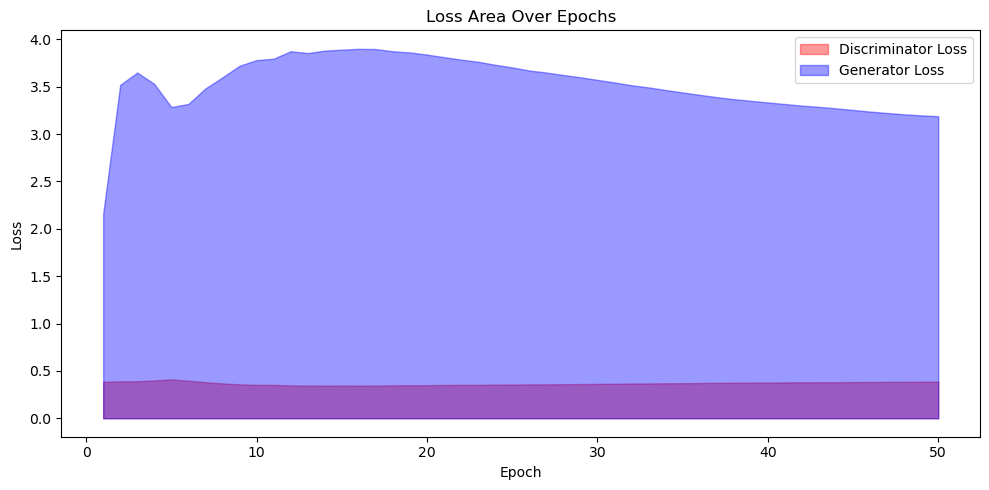

In [53]:
def plot_loss_area(d_losses, g_losses):
    import numpy as np
    epochs = range(1, len(d_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.fill_between(epochs, d_losses, label='Discriminator Loss', alpha=0.4, color='red')
    plt.fill_between(epochs, g_losses, label='Generator Loss', alpha=0.4, color='blue')
    plt.title('Loss Area Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_area(d_losses, g_losses)